In [1]:

import numpy as np
import matplotlib.pyplot as plt 
import scipy

import sys
sys.path.append("/home/calab912/Documents/fdm-hybrid-scheme/")

import src.fd as fd 
import src.config as config
import src.animation as animation 
import demonstration.spectral_derivative as sd 

In [30]:

class IPRReconstruction:
    def __init__(self, x, lam = 1, cutoff = 100):
        self.cutoff                 = cutoff
        self.lam                    = lam
        W                           = self.directW(self.shiftx(x), int(len(x)/2), lam)
        self.p, self.l, self.u      = scipy.linalg.lu(W, permute_l=False)

    def poly(self, N):
        return scipy.special.chebyt(N)

    def reconstruct(self, g):
        f = np.poly1d([])
        for l, coeff in enumerate(g):
            f += coeff * self.poly(l)

        return f

    def __call__(self, x, order = 0):
        return self.rec.deriv(order)((x - self.s)*self.c) * self.c**order


    #Construct matrices T and V recursively for arbitrary lambda
    def directW(self, x, N, lam):
        # Even
        W = np.zeros((2*N, 2*N), dtype=complex)

        for l in range(2*N):
            W[:, l] = scipy.fft.fft(self.poly(l)(x))

        return W


    def shiftx(self, x):
        dx = x[1] - x[0]
        self.a = x[0]
        self.b = x[-1]
        self.s = (self.a + self.b)/2
        self.c = 1 / ((self.b - self.a)/2)
        sx = (x - self.s) * self.c
        return  sx

    def gaussWithTruncation(self, A, B):
        """
        Solve Ax = B using Gaussian elimination and LU decomposition with truncation for stability of IPR
        """
        # LU decomposition with pivot
        p, l, u = scipy.linalg.lu(A, permute_l=False)
        return self.solveLUWithTruncation(B, p, l, u)


    def compute(self, psi, p = None, l = None, u = None):
        B = scipy.fft.fft(psi)

        if p is None:
            p = self.p
        if l is None:
            l = self.l
        if u is None:
            u = self.u

        # forward substitution to solve for Ly = B
        y = np.zeros(B.size, dtype=complex)
        for m, b in enumerate((p.T @ B).flatten()):
            y[m] = b
            # skip for loop if m == 0
            if m:
                for n in range(m):
                    y[m] -= y[n] * l[m,n]
            y[m] /= l[m, m]

        # truncation for IPR
        c = np.abs(y) < self.cutoff * np.finfo(float).eps
        y[c] = 0

        # backward substitution to solve for y = Ux
        x = np.zeros(B.size, dtype=complex)
        lastidx = B.size - 1  # last index
        for midx in range(B.size):
            m = B.size - 1 - midx  # backwards index
            x[m] = y[m]
            if midx:
                for nidx in range(midx):
                    n = B.size - 1  - nidx
                    x[m] -= x[n] * u[m,n]
            x[m] /= u[m, m]
        self.rec = self.reconstruct(x)

class FourierExtension:
    def __init__(self, N, Ncoll, theta, chi, cutoff):
        self.N, self.Ncoll, self.theta, self.chi, self.cutoff = N, Ncoll, theta, chi, cutoff 
        self.Meven = self.getFPICSUEvenMatrix(N, Ncoll, theta, chi) 
        self.Modd  = self.getFPICSUOddMatrix (N, Ncoll, theta, chi) 

        self.dx    = chi / (Ncoll - 1) 
        self.x     = np.arange(-Ncoll + 1, Ncoll) * self.dx

        self.Meveninv  = self.invertRealM(self.Meven, cutoff)
        self.Moddinv   = self.invertRealM(self.Modd,  cutoff)

    def getX(self): 
        return self.x, self.dx
    
    def getFPICSUEvenMatrix(self, N, Ncoll, theta, chi): 
        M  = np.zeros((Ncoll, N))
        dx = chi / (Ncoll - 1) 
        for i in range(Ncoll):
            for j in range(N):
                #Collocation points uniformly distributed over the positive half
                #of the physical interval x in [0, chi]
                M[i, j] = np.cos(j * np.pi / theta * i * dx)
        return M

    def getFPICSUOddMatrix(self, N, Ncoll, theta, chi): 
        M = np.zeros((Ncoll, N))
        dx = chi / (Ncoll - 1) 
        for i in range(Ncoll):
            for j in range(N):
                #Collocation points uniformly distributed over the positive half
                #of the physical interval x in [0, chi]
                M[i, j] = np.sin(j * np.pi / theta * i * dx)
        return M

    def invertRealM(self, M, cutoff):
        U, s, Vh = scipy.linalg.svd(M)
        sinv = np.zeros(M.T.shape)
        for i in range(np.min(M.shape)):
            if s[i] < cutoff:
                sinv[i, i] = 0
            else:
                sinv[i, i] = 1/s[i]
        return Vh.T @ sinv @ U.T
    
    
    def rescaleToPhysical(self, x, getSlope = False): 
        a = x[0]
        b = x[-1]
        L = b -a 
        sx = ( x - a ) / L
        sx = sx * (2*self.chi) - self.chi
        if getSlope:

            return sx, a * 2 * self.chi / L + self.chi, 2 * self.chi / L 
        else:
            return sx 

    def rescaleToExtended(self, x): 
        a = x[0]
        b = x[-1]
        sx = ( x - a ) / ( b - a ) 
        sx = sx * (2*self.theta) - self.theta
        return sx
    

    def convertToFourierCoeff(self, aodd, aeven):
        k = np.arange(-self.N, self.N) * np.pi / self.theta
        fhat = np.zeros(2*self.N, dtype=complex)

        for j, (oddcoeff, evecoeff) in enumerate(zip(aodd, aeven)):
            fhat[ j + self.N] +=   oddcoeff / (2j) + evecoeff / (2)
            fhat[-j + self.N] += - oddcoeff / (2j) + evecoeff / (2)


        return np.fft.ifftshift(fhat), np.fft.ifftshift(k) 

    def reconstructFourier(self, x, fhat): 

        rec  = np.zeros (   x.shape, dtype=complex) 
        ks   = np.fft.ifftshift(np.arange( -self.N, self.N) * np.pi / self.theta)

        for k, coeff in zip(ks, fhat): 
            rec += coeff * np.exp(1j * (k * x))
        return rec
    
    def iterativeRefinement(self, M, Minv, f, threshold = 100, maxiter = 5): 
        a       = Minv @ f
        r       = M @ a - f
        counter = 0
        while np.linalg.norm(r) > 100 * np.finfo(float).eps * np.linalg.norm(a) and counter < maxiter: 
            delta    = Minv @ r
            a        = a - delta 
            r        = M @ a - f
            counter += 1
        return a

    def computeExtension(self, f, Ni, threshold = 10, maxiter = 3): 
        refeven  = ((f + np.flip(f)).real/2)[self.Ncoll-1:]
        refodd   = ((f - np.flip(f)).real/2)[self.Ncoll-1:]
        imfeven  = ((f + np.flip(f)).imag/2)[self.Ncoll-1:]
        imfodd   = ((f - np.flip(f)).imag/2)[self.Ncoll-1:]
        aeven    = self.iterativeRefinement(self.Meven, self.Meveninv, refeven, threshold = threshold, maxiter = maxiter) + 1j * self.iterativeRefinement(self.Meven, self.Meveninv, imfeven, threshold = threshold, maxiter = maxiter)
        aodd     = self.iterativeRefinement(self.Modd,  self.Moddinv,  refodd,  threshold = threshold, maxiter = maxiter) + 1j * self.iterativeRefinement(self.Modd,  self.Moddinv,  imfodd,  threshold = threshold, maxiter = maxiter)
        fhat, k  = self.convertToFourierCoeff(aodd, aeven) 
        frec     = self.fourierInterpolation(fhat, Ni)
        return frec, fhat
    
    def evolve(self, f, dt, threshold = 10, maxiter = 3): 
        refeven  = ((f + np.flip(f)).real/2)[self.Ncoll-1:]
        refodd   = ((f - np.flip(f)).real/2)[self.Ncoll-1:]
        imfeven  = ((f + np.flip(f)).imag/2)[self.Ncoll-1:]
        imfodd   = ((f - np.flip(f)).imag/2)[self.Ncoll-1:]
        aeven    = self.iterativeRefinement(self.Meven, self.Meveninv, refeven, threshold = threshold, maxiter = maxiter) + 1j * self.iterativeRefinement(self.Meven, self.Meveninv, imfeven, threshold = threshold, maxiter = maxiter)
        aodd     = self.iterativeRefinement(self.Modd,  self.Moddinv,  refodd,  threshold = threshold, maxiter = maxiter) + 1j * self.iterativeRefinement(self.Modd,  self.Moddinv,  imfodd,  threshold = threshold, maxiter = maxiter)
        fhat, k  = self.convertToFourierCoeff(aodd, aeven) 
        frec     = self.reconstructFourier(self.x, fhat, dt)
        return frec
    
    def plotApproximationErorr(self, xext, forg, frec):
        plt.title("Approximation error of f")
        plt.yscale("log")
        plt.plot(xext, np.abs(forg - frec))
        plt.show() 


    def fourierInterpolation(self, fhat, Ni):
        N = len(fhat) 
        Npad = int(Ni/2 - N/2) 
        ft   = np.fft.fftshift(fhat)
        ft_pad = np.concatenate([np.zeros(Npad), ft, np.zeros(Npad)])
        fint = scipy.fft.ifft(np.fft.fftshift(ft_pad), norm="forward")
        return fint

In [25]:


# Generate analytical solution for the 1D free Schrödinger equation
# Li test 1
def generate1DGaussian(x0, x, t, m = 1, hbar = 1, alpha=1.0 / 10):
    psi = np.sqrt(1 / (alpha + 1.0j * t * hbar/m)) * np.exp(
        -((x - x0) ** 2) / (2 * (alpha + 1.0j * t * hbar/m))
    )
    return psi

def periodic1DGaussian(x, dx, t, m = 1, hbar = 1,  x0=5, alpha= 1/20, eps=0, L=10, N=100):
    psi = eps + 0j
    N = 40
    for i in range(-N, N + 1):
        psi += generate1DGaussian(x0, x + L * i, t, m, hbar, alpha)
    return psi 

class Scheme:
    def __init__(self, config, generateIC):

        #print(f"Constructing {self.getName()} scheme")

        self.config              = config
        self.generateIC          = generateIC

        # Set up time management
        self.t0                  = config["t0"]
        self.t                   = config["t0"]
        self.dt                  = config["dt"]
        self.tEnd                = config["tEnd"]
        self.useAdaptiveTimestep = config["useAdaptiveTimestep"]
        self.outputTimestep      = config["outputTimestep"]
        self.timeOrder           = config["timeOrder"]
        self.cfl                 = config["cfl"]
        self.ntmax               = config["maximumNumberOfTimesteps"]



        # Set up grid (evenly-spaced with or without ghost boundary)
        self.dimension           = config["dimension"]
        self.stencilOrder        = config["stencilOrder"] 

        #Since we use np.roll for finite differences there is no need for a ghost boundary with periodic boundary conditions
        self.usePeriodicBC     = config["usePeriodicBC"]
        self.ghostBoundarySize = config["boundarySize"]

        self.useBC = config["useBC"]

        # Set up simulation grid
        N                = config["resolution"]
        self.L0, self.L1 = config["domainSize"]
        self.boxWidth  = self.L1 - self.L0 # physical box width

        self.innerN    = N
        self.dx        = self.boxWidth / (N - 1)

        #Handle ghost boundary
        self.totalN    = self.innerN + 2 * self.ghostBoundarySize
        N              = self.totalN
        Ll             = self.L0 - self.dx * self.ghostBoundarySize
        Lh             = self.L1 + self.dx * self.ghostBoundarySize
        self.PLMWidth  = Lh - Ll # PLM box width

        #Position of lower and upper grid boundary
        self.Ll = Ll 
        self.Lh = Lh 
        

        self.boundaryColumns = np.concatenate([np.arange(self.ghostBoundarySize), \
                                            np.arange(self.innerN + self.ghostBoundarySize, self.innerN + 2 * self.ghostBoundarySize)])
        self.innerColumns    = np.arange(self.ghostBoundarySize, self.innerN + self.ghostBoundarySize)


        self.boundary = np.ix_(self.boundaryColumns)
        self.inner    = np.ix_(self.innerColumns)

        #Create 1D grid
        xlin, self.dx = sd.computeX(self.Ll, self.Lh, self.totalN)
        self.grid = [xlin]

        self.debug = config["debug"]       
        self.hbar  = config["hbar"]
        self.m     = config["m"]
        self.eta   = self.hbar / self.m
        

        # Set up global parameters and constants
        self.G            = config["gravity"]
        self.useCosmology = config["useCosmology"]
        self.useHybrid    = False


        self.C_potential       = config["C_potential"]
        self.C_parabolic       = config["C_parabolic"]



        self.dt            = self.getTimeStep()
        
        self.psi           = self.generateIC(*self.grid, self.dx, self.t          , self.m, self.hbar)
        self.potential     = np.zeros(self.psi.shape)
        self.fields        = self.psi

        #Initialise buffer for fields at t - dt for leapfrog method
        self.old_fields    = self.generateIC(*self.grid, self.dx, self.t - self.dt, self.m, self.hbar)


    def getGrid(self):
        return self.grid

    def getTime(self):
        return self.t

    def getTimeStep(self): 
        if self.useAdaptiveTimestep:
            return self.getAdaptiveTimeStep()
        else:
            return self.dt 

    def getAdaptiveTimeStep(self):
        raise NotImplementedError("Please Implement this method")

    def getConfig(self):
        return self.config

    def getUpdatedFields(self, dt, fields):
        raise NotImplementedError("Please Implement this method")

    def setBoundaryConditions(self, fields):
        raise NotImplementedError("Please Implement this method")

    def getScaleFactor(self):
        return 1

    def run(self, tfin = None, enableBackward = False):
        if tfin is None:
            tfin = self.tEnd
        i = 0
        while(self.t < tfin - 1e-15):
            dt = self.getTimeStep()

            if (tfin - self.t < dt):
                dt = tfin - self.t

            self.step(dt)
            i += 1
            if i > self.ntmax:
                print("Maximum number of timesteps reached. Aborting.")
                break
        
        if enableBackward:
            while(tfin < self.t):
                dt = self.getTimeStep()

                if (self.t - tfin < dt):
                    dt = self.t - tfin

                self.step(-dt)
                i += 1
                if i > self.ntmax:
                    print("Maximum number of timesteps reached. Aborting.")
                    break
        print(f"Finished in {i} time steps")


    #Dummy function for implementation of first kick in kick-drift-kick scheme
    def kick1(self, fields, dt):
        return fields

    #Dummy function for implementation of second kick in kick-drift-kick scheme
    #Here the gravitational potential should be updated
    def kick2(self, fields, dt):
        return fields

    def getName(self):
        raise NotImplementedError("Please Implement this method")

    def getPotential(self):
        return self.potential

    def getScaleFactor(self):
        if self.useCosmology:
            return 1
        else:
            return 1

    def getPsi(self):
        return self.psi 

    def setPsi(self, psi):
        self.psi = psi 
        if self.G != 0:
            self.potential = self.computePotential(np.abs(self.psi)**2)

    def getDensity(self):
        return np.abs(self.psi) ** 2

    def getPhase(self):
        return fd.make_continuous(np.angle(self.psi))
        
    def getAdaptiveTimeStep(self):
        t1 = self.C_parabolic * self.dx**2/self.eta
        if self.G > 0:
            t2 = self.C_potential    * self.hbar/np.max(np.abs(self.potential) + 1e-8)
        else:
            t2 = 1e4
        
        return np.min([t1, t2])

    def setBoundaryConditions(self, psi, t):
        f = self.generateIC(*self.grid, self.dx, t, self.m, self.hbar)
        psi[self.boundary] = f[self.boundary]
        
    def computeRelErrorArray(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        return np.abs(np.abs(self.psi[self.inner])**2 - np.abs(psi_ref[self.inner])**2) / (np.abs(psi_ref[self.inner])**2)
    
    def computeAbsErrorArray(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        return np.abs(np.abs(self.psi[self.inner])**2 - np.abs(psi_ref[self.inner])**2)
    
    def computeRelError(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        l_infty_diff = np.max(np.abs(np.abs(self.psi[self.inner])**2 - np.abs(psi_ref[self.inner])**2))
        l_infty_ref  = np.max(np.abs(psi_ref)**2)
        return l_infty_diff/l_infty_ref 


    def computeRMSError(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        d1 = np.abs(self.psi[self.inner])**2
        d2 = np.abs(psi_ref[self.inner])**2
        RMS = np.sqrt(np.sum((d1 - d2)**2))
        RMS /= len(d1)
        return RMS
    

class FourierExtensionScheme(Scheme): 
    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)

        self.upsampleGrid = np.linspace(self.grid[0][0], self.grid[0][-1], 2 * len(self.grid[0]))

        N      = int(self.totalN/4)
        Ncoll  = int(self.totalN/2)
        theta  = 2
        chi    = theta/2 
        cutoff = 1e-14

        self.fe     = FourierExtension( N, Ncoll, theta, chi, cutoff = cutoff)
        self.psi    = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        self.fields = self.psi 
        self.counter = 0
        self.alpha                  = config.get("alpha", 0) 
        self.p                      = config.get("p", 1) 

    def step(self, dt):
        if self.useBC:
            self.setBoundaryConditions(self.psi, self.t)

        Coeff1 = 1j * 1/2  * dt * self.eta
        x      = self.grid[0]


        if 0:
            psirec, fhat   = self.fe.computeExtension  (self.psi[:-1], self.totalN, maxiter=3) 
            self.psi[:-1]  = self.fe.reconstructFourier(x, fhat, dt) 
        elif 1: 
            xscale, shift, slope = self.fe.rescaleToPhysical(x[:-1], getSlope=True)
            dx                   = xscale[1] - xscale[0]
            xint                 = np.pad(xscale, (0, self.totalN), mode="linear_ramp", end_values=(0, xscale[-1] + self.totalN * dx))
            xext                 = (xint + shift)/slope
            frec, fhat           = self.fe.computeExtension(self.psi[:-1], (len(x)-2)*2, maxiter=10)
            frec                 = np.roll(frec, self.fe.Ncoll - 1)

            Nfull                = self.totalN 

            if 0: 
                #frecref                = self.fe.reconstructFourier(xint, fhat)[:-3]
                #print(frec.shape, frecref.shape) 
                #print(np.mean(np.abs(frec - frecref)))
                #print(frec[0], frec[1], frec[-2], frec[-1])

                plt.title("fourier extension") 
                plt.plot(frec.real)
                plt.plot(frec.imag)
                plt.axvspan(0, Nfull-1, alpha=0.2)
                plt.show()
                plt.title("fourier extension") 
                plt.plot(np.abs(frec.real[:Nfull] - self.psi[:Nfull].real), label="real")
                plt.plot(np.abs(frec.imag[:Nfull] - self.psi[:Nfull].imag), label="imag")
                plt.yscale("log")
                plt.legend()
                plt.axvspan(0, Nfull-1, alpha=0.2)
                plt.show()


            if 0:
                f = self.psi 
                forg = np.pad(f, (0, Nfull - 1), mode="constant")
                plt.title("Periodic extension of f(x) = e^x + i e^x from [-pi/2, pi/2] to [-pi, pi]")
                plt.plot(xext[:-3], frec.real,       label="Real Extension") 
                plt.plot(xext, forg.real, label="Real Original") 
                plt.plot(xext[:-3], frec.imag,       label="Imag Extension") 
                plt.plot(xext, forg.imag, label="Imag Original") 
                plt.legend()
                plt.ylim(np.min(frec) - 1, np.max(frec) + 1)
                plt.show() 

                self.fe.plotApproximationErorr(x[:-1], forg[:Nfull-1], frec[:Nfull-1])
            
            frec[:Nfull-1] = self.psi[:Nfull-1]
            k = sd.computeK(frec, self.dx, sd.PERIODIC) 
            fhat = scipy.fft.fft(frec)

            if 0:
                plt.title("the spectrum") 
                plt.plot(k, np.abs(fhat)) 
                plt.yscale("log") 
                plt.show()

            fhat = fhat * np.exp(-self.alpha * (2*k/len(fhat))**(2*self.p))
            
            fhat = fhat * ( 1 - Coeff1 * k**2 + (- Coeff1 * k**2)**2/2 + (- Coeff1 * k**2)**3/6  + (- Coeff1 * k**2)**4/24)
            #fhat = np.exp(-Coeff1 * k**2) * fhat

            self.psi[:Nfull-1] = scipy.fft.ifft(fhat)[:Nfull-1]


            if 0:
                plt.title("Relative errors") 
                plt.plot(self.computeAbsErrorArray()) 
                plt.yscale("log") 
                plt.show()


        self.counter += 1 

        self.t += dt

    def getName(self):
        return "fourier extension scheme"
    
    def getDx(self): 
        return self.x[1] - self.x[0]
    


Finished in 563 time steps


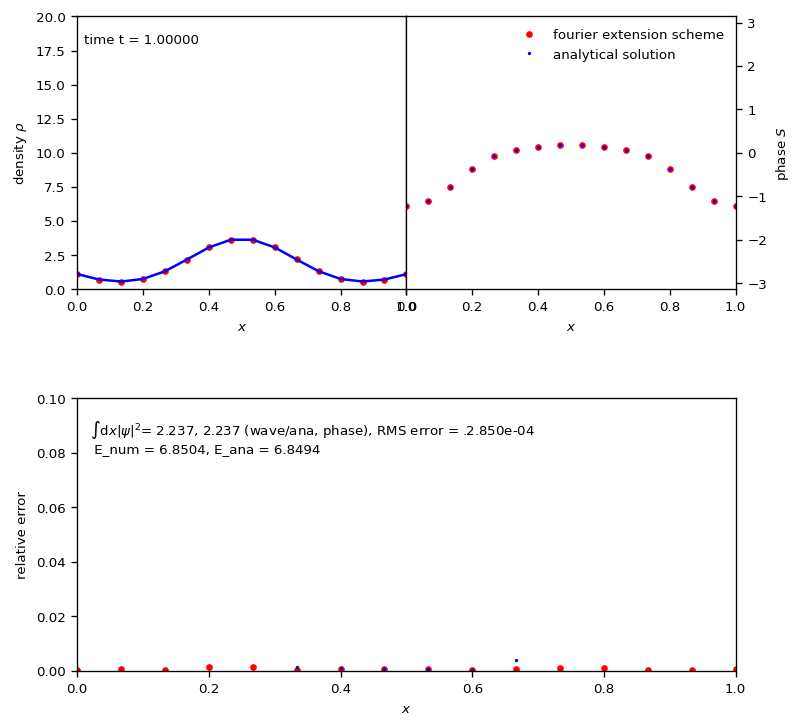

In [28]:

def periodic1DGaussian(x, dx, t, m = 1, hbar = 1,  x0=.5, alpha= 1/20, eps=0, L=1, N=100):
    psi = eps + 0j
    N = 40
    L = 4
    for i in range(-N, N + 1):
        psi += generate1DGaussian(x0, x + L * i, t, m, hbar, alpha)
    return psi 

c = config.generateConfig()
c["t0"]                         = 0.0
c["tEnd"]                       = 1.0
c["resolution"]                 = 16
c["boundarySize"]               = 6
c["useBC"]                      = True
c["domainSize"]                 = [0, 1]
c["xlim"]                       = [0, 1]
c["dpi"]                        = 120
c["densityYlim"]                = [0, 20]
c["useAdaptiveTimestep"]        = True 
c["C_parabolic"]                = 0.4
c["alpha"]                      = 16 * np.log(10)
c["p"]                          = 50 
scheme = FourierExtensionScheme(c, periodic1DGaussian) 
scheme.run()
animation.drawFrame(scheme)

In [10]:

class SubregionScheme(Scheme):
    def __init__(self, config, generateIC, scheme):
        super().__init__(config, generateIC)
  
        if "printGrid" in config: 
            self.print_grid = config["printGrid"]
        else:
            self.print_grid = False

        self.patchSize = config["patchSize"]

        # Create sub patches
        self.NPatch = int(self.innerN/self.patchSize)
        self.patchWidth = self.dx * (self.patchSize - 1)

        if self.print_grid: 
            print(f"Domain size = {self.Lh - self.Ll} Patch number = {self.NPatch}, patch size = {self.patchSize} and patch width = {self.patchWidth} and patch number times patch width = {self.patchWidth * self.NPatch}")

        self.patches = []
    
        patchConfig = dict(config)
        patchConfig["resolution"]  = self.patchSize
        patchConfig["useBC"] = False
        for i in range(self.NPatch):
            patchConfig["domainSize"] = [self.L0 + (i) * self.dx * self.patchSize, self.L0 + i * self.dx * self.patchSize + self.patchWidth]
            self.patches.append(scheme(patchConfig, generateIC))
            if self.print_grid:
                print(f"Patch {i}: domainSize: ", patchConfig["domainSize"], " the grid: ", self.patches[i].grid, " dx: ", self.patches[i].dx)

        if self.print_grid:
            print("The master grid: domainSize: ", config["domainSize"], " the grid: ", self.grid, " dx: ", self.dx)

        #Make sure everything agrees on the bit-level
        for i in range(self.NPatch):
            self.patches[i].dx = self.dx 

            i0 =  i      * self.patchSize
            i1 = (i + 1) * self.patchSize + 2 * self.ghostBoundarySize
            if self.print_grid:
                print(f"Filling patch {i} with data from {i0} to {i1 - 1}")
            
            self.patches[i].psi = np.copy(self.psi[ i0 : i1 ])

        self.debugWavefunction = False 
        self.debugShiftfunction = False 


    #def getUpdatedFields(self, t, dt, old_psi):
    def step(self, dt):
        #self.psi = np.copy(old_psi)

        print_grid = self.print_grid
        
        if 0:
            plt.title("Before boundary overwrite")
            plt.plot(self.psi.real)
            plt.plot(self.psi.imag)
            plt.show()

        if 1:
            f = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)

            if print_grid:
                print(f"Writing BC to {self.boundary}")


            #Set outer ghost zone
            self.psi[self.boundary] = f[self.boundary]

        else:
            self.psi[ :self.ghostBoundarySize] = np.roll(self.psi, 2*self.ghostBoundarySize)[:self.ghostBoundarySize]
            self.psi[-self.ghostBoundarySize:] = np.roll(self.psi,-2*self.ghostBoundarySize)[-self.ghostBoundarySize:]

        if 0:
            plt.title("After boundary overwrite")
            plt.plot(self.psi.real)
            plt.plot(self.psi.imag)
            plt.show()

        patchpgb  = self.patchSize + 2 * self.ghostBoundarySize

        #Fill ghost zones of patches and set boundary conditions
        for i in range(self.NPatch):

            i0 =  i      * self.patchSize
            i1 = (i + 1) * self.patchSize + 2 * self.ghostBoundarySize
            if print_grid:
                print(f"Filling patch {i} with data from {i0} to {i1 - 1}")
            
            self.patches[i].psi = np.copy(self.psi[ i0 : i1 ])
            if print_grid:
                print(f"This means the points {self.grid[0][ i0 : i1 ]} that should include the patch's boundary points {self.patches[i].grid[0][self.patches[i].boundary]} ")
            

        #Advance patches 
        for i in range(self.NPatch):
            self.patches[i].debugWavefunction = self.debugWavefunction 
            self.patches[i].debugShiftfunction = self.debugShiftfunction
            self.patches[i].step(dt)

        #Write updated patch data back to global array
        for i in range(self.NPatch):
            i0 = self.ghostBoundarySize + i * self.patchSize
            i1 = self.ghostBoundarySize + (i + 1) * self.patchSize

            if print_grid:
                    print(f"Writing patch {i} inner {self.patches[i].inner[0], self.patches[i].inner[-1] - 1} to [{i0}, {i1 - 1}]")
            self.psi[ i0 : i1 ] = self.patches[i].psi[self.patches[i].inner]
        
        self.t += dt
        #return self.psi# - old_psi



    def getName(self):
        return "subregion scheme"
    

    def getAdaptiveTimeStep(self):
        t1 = self.C_parabolic * self.dx**2/self.eta
        if self.G > 0:
            t2 = self.C_potential    * self.hbar/np.max(np.abs(self.potential) + 1e-8)
        else:
            t2 = 1e4
        t3 = 1e6#self.ghostBoundarySize * 4/np.pi**2  * self.dx**3
        
        return np.min([t1, t2, t3])


Finished in 19846 time steps


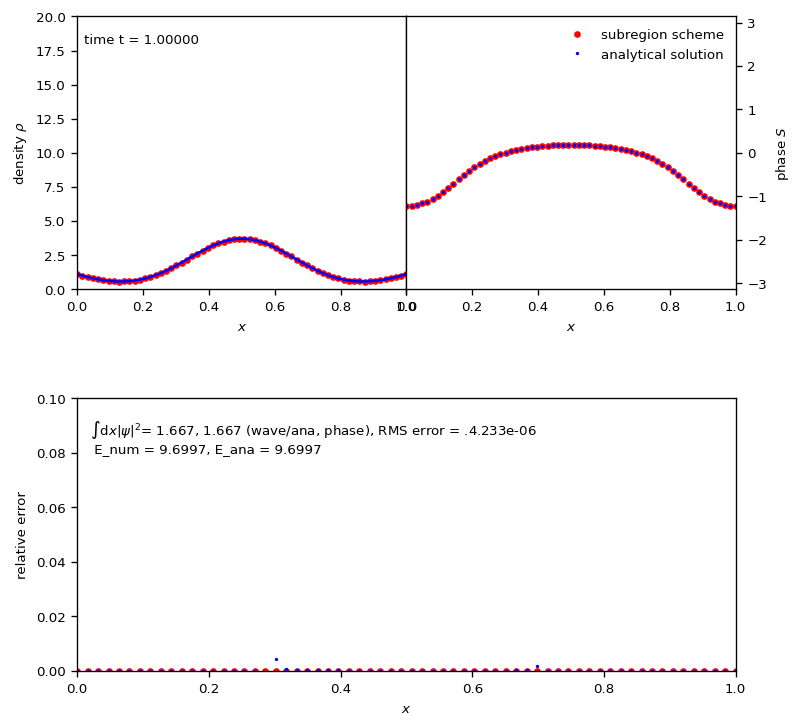

In [29]:

c = config.generateConfig()
c["t0"]                         = 0.0
c["tEnd"]                       = 1
c["resolution"]                 = 64
c["patchSize"]                  = 16
c["boundarySize"]               = 6
c["useBC"]                      = True
c["domainSize"]                 = [0, 1]
c["xlim"]                       = [0, 1]
c["dpi"]                        = 120
c["densityYlim"]                = [0, 20]
c["useAdaptiveTimestep"]        = True 
c["C_parabolic"]                = 0.2
c["printGrid"]                  = False
c["alpha"]                      = 0#16 * np.log(10)
c["p"]                          = 50 
scheme = SubregionScheme(c, periodic1DGaussian, FourierExtensionScheme) 
scheme.run()
animation.drawFrame(scheme)


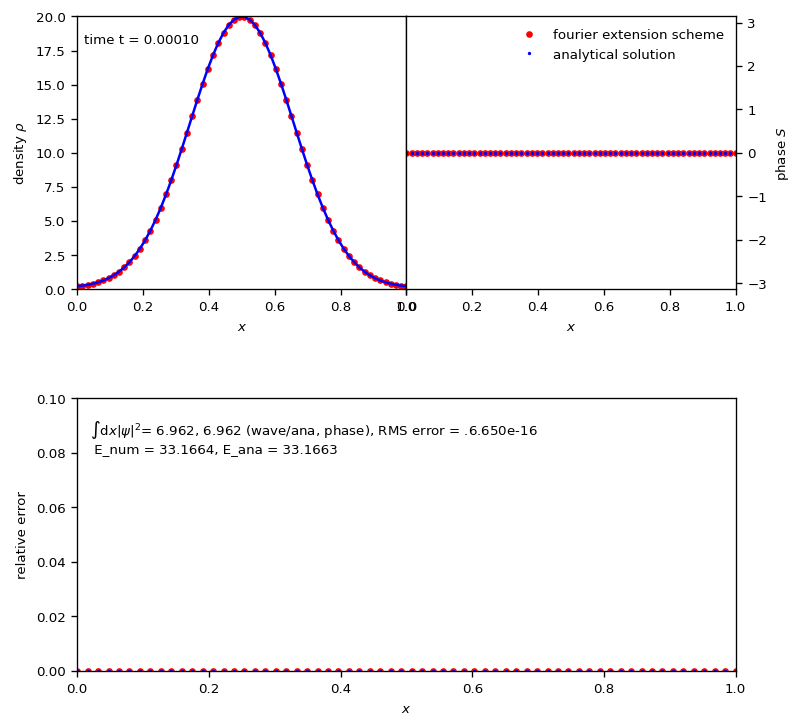

In [26]:

def periodic1DGaussian(x, dx, t, m = 1, hbar = 1,  x0=.5, alpha= 1/20, eps=0, L=1, N=100):
    psi = eps + 0j
    N = 40
    L = x[-1] - x[0]
    for i in range(-N, N + 1):
        psi += generate1DGaussian(x0, x + L * i, t, m, hbar, alpha)
    return psi 

c = config.generateConfig()
c["t0"]                         = 0.0
c["tEnd"]                       = 2.0
c["resolution"]                 = 64
c["boundarySize"]               = 4
c["useBC"]                      = True
c["domainSize"]                 = [0, 1]
c["xlim"]                       = [0, 1]
c["dpi"]                        = 120
c["densityYlim"]                = [0, 20]
c["useAdaptiveTimestep"]        = True 
c["C_parabolic"]                = 0.4
scheme = FourierExtensionScheme(c, periodic1DGaussian) 
scheme.step(1e-4)
animation.drawFrame(scheme)


In [402]:
c = config.generateConfig()
c["t0"]                         = 0.0
c["tEnd"]                       = 2.0
c["resolution"]                 = 128
c["patchSize"]                  = 32
c["boundarySize"]               = 8
c["useBC"]                      = False
c["domainSize"]                 = [0, 1]
c["xlim"]                       = [0, 1]
c["dpi"]                        = 120
c["densityYlim"]                = [0, 20]
c["useAdaptiveTimestep"]        = True 
c["C_parabolic"]                = 0.4
c["printGrid"]                  = False

scheme = SubregionScheme(c, periodic1DGaussian, FourierExtensionScheme) 
scheme.run()
animation.drawFrame(scheme)

KeyboardInterrupt: 